## Bibliotecas Utilizadas

In [1]:
import pandas as pd
import numpy as np
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
pio.renderers.default = 'browser'
import plotly.graph_objects as go
import sympy as sy
import scipy as sp
import matplotlib.dates as mdates
pd.set_option('display.max_rows', 20)
np.set_printoptions(suppress=True, precision=5)

## Introdução

A curva de juros (yield curve) é formada pelas taxas de juros (yields) de títulos públicos ao longo de um range de vencimentos (maturities), estas taxas são influenciadas por inúmeras variáveis econômicas sendo a expectativa de inflação uma das mais importantes. Por sua vez, a análise de fatores por componentes principais (PCA - Principal Component Analysis) é uma análise estatística que permite transformar um conjunto de variáveis originais em um número reduzido de fatores que conseguiria capturar o comportamento das variáveis originais. 

O objetivo deste estudo foi decompor a curva de juros dos EUA utilizando análise de fatores por componentes principais (PCA) para identificar componentes principais previstos pela teoria: nível, inclinação e curvatura. 


## Preparando a Base de Dados

### Extração da Base de Dados

Os dados foram coletados no site do Federal Reserve que disponibiliza um arquivo CSV com os yields de diferentes maturities com prazos que vão de 1 até 30 anos, neste estudo foram utilizados os yields zero-cupom, ou seja, que não pagam juros (cupons) ao longo do período. 

Fonte: https://www.federalreserve.gov/data/nominal-yield-curve.htm

In [2]:
data = pd.read_csv(r"C:\Users\emanu\Downloads\feds200628.csv")
data

,Date,BETA0,BETA1,BETA2,BETA3,SVEN1F01,SVEN1F04,SVEN1F09,SVENF01,SVENF02,...,SVENY23,SVENY24,SVENY25,SVENY26,SVENY27,SVENY28,SVENY29,SVENY30,TAU1,TAU2
0,1961-06-14,3.917606,-1.277955,-1.949397,0.000000,3.8067,3.9562,NaN,3.5492,3.8825,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.339218,-999.990000
1,1961-06-15,3.978498,-1.257404,-2.247617,0.000000,3.8694,4.0183,NaN,3.5997,3.9460,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.325775,-999.990000
2,1961-06-16,3.984350,-1.429538,-1.885024,0.000000,3.8634,4.0242,NaN,3.5957,3.9448,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.348817,-999.990000
3,1961-06-19,4.004379,-0.723311,-3.310743,0.000000,3.9196,4.0447,NaN,3.6447,3.9842,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.282087,-999.990000
4,1961-06-20,3.985789,-0.900432,-2.844809,0.000000,3.8732,4.0257,NaN,3.5845,3.9552,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.310316,-999.990000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16443,2024-06-24,2.046762,3.517820,-0.000125,7.241848,4.3370,3.9544,4.4868,4.5603,4.0834,...,4.4590,4.4609,4.4607,4.4585,4.4545,4.4487,4.4413,4.4324,1.923987,16.141559
16444,2024-06-25,2.045934,3.526612,-0.000164,7.204947,4.3253,3.9356,4.4683,4.5528,4.0690,...,4.4443,4.4465,4.4466,4.4447,4.4409,4.4354,4.4283,4.4197,1.909825,16.213917
16445,2024-06-26,1.872640,3.699263,-0.000139,7.927864,4.4063,4.0316,4.5761,4.6189,4.1571,...,4.5312,4.5312,4.5290,4.5246,4.5182,4.5099,4.4999,4.4884,2.054578,15.742303
16446,2024-06-27,1.997212,3.580686,-0.000139,7.549143,4.3649,3.9996,4.5526,4.5841,4.1140,...,4.5125,4.5139,4.5131,4.5102,4.5053,4.4987,4.4903,4.4805,1.947326,15.957330


Da base de dados filtramos os títulos zero-cupom (SVENY) e definimos a coluna "Date" como nosso index e o transformamos como datetime(). 

In [3]:
data.index = pd.to_datetime(data['Date'])
data = data.iloc[:, 68:98].dropna()
data

,SVENY01,SVENY02,SVENY03,SVENY04,SVENY05,SVENY06,SVENY07,SVENY08,SVENY09,SVENY10,...,SVENY21,SVENY22,SVENY23,SVENY24,SVENY25,SVENY26,SVENY27,SVENY28,SVENY29,SVENY30
Date,,,,,,,,,,,,,,,,,,,,,
1985-11-25,7.8551,8.3626,8.7469,9.0408,9.2686,9.4481,9.5924,9.7110,9.8108,9.8969,...,10.4821,10.5196,10.5553,10.5893,10.6217,10.6526,10.6819,10.7099,10.7365,10.7618
1985-11-26,7.8527,8.3575,8.7420,9.0376,9.2677,9.4494,9.5956,9.7154,9.8158,9.9015,...,10.4497,10.4827,10.5139,10.5435,10.5715,10.5982,10.6234,10.6474,10.6701,10.6917
1985-11-27,7.8425,8.3522,8.7339,9.0231,9.2453,9.4193,9.5586,9.6727,9.7688,9.8515,...,10.4157,10.4514,10.4853,10.5176,10.5482,10.5773,10.6049,10.6311,10.6560,10.6796
1985-11-29,7.7914,8.3148,8.6991,8.9852,9.2024,9.3712,9.5061,9.6172,9.7115,9.7938,...,10.3798,10.4172,10.4526,10.4861,10.5179,10.5479,10.5763,10.6032,10.6287,10.6528
1985-12-02,7.8176,8.3457,8.7359,9.0294,9.2550,9.4327,9.5766,9.6962,9.7983,9.8874,...,10.4856,10.5206,10.5534,10.5842,10.6131,10.6402,10.6657,10.6897,10.7123,10.7335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-24,5.0054,4.6474,4.4235,4.2892,4.2145,4.1795,4.1705,4.1782,4.1963,4.2204,...,4.4483,4.4548,4.4590,4.4609,4.4607,4.4585,4.4545,4.4487,4.4413,4.4324
2024-06-25,5.0046,4.6412,4.4140,4.2776,4.2016,4.1656,4.1559,4.1631,4.1808,4.2047,...,4.4331,4.4399,4.4443,4.4465,4.4466,4.4447,4.4409,4.4354,4.4283,4.4197
2024-06-26,5.0429,4.7001,4.4838,4.3533,4.2810,4.2477,4.2402,4.2494,4.2690,4.2946,...,4.5236,4.5287,4.5312,4.5312,4.5290,4.5246,4.5182,4.5099,4.4999,4.4884


### Estatística Descritiva da Base de Dados

Abaixo plotamos a série histórica dos yields em um boxplot, é possível notar que de forma geral os valores centrais medidos pela mediana tendem a ser mais elevados na medida em que se avança para vencimentos mais longos, este comportamento é esperado visto que há um prêmio de risco ao carregar títulos de prazos mais longos. 

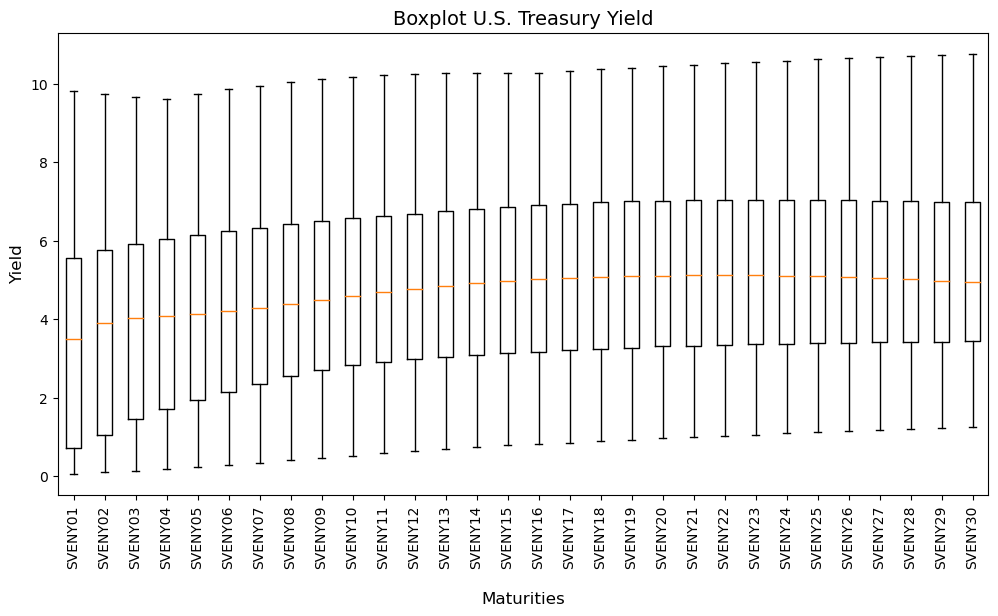

In [4]:
plt.figure(figsize=(12,6))

plt.boxplot(data)

plt.title('Boxplot U.S. Treasury Yield', fontsize = 14)
plt.ylabel('Yield', fontsize = 12)
plt.xlabel('\nMaturities', fontsize = 12)
plt.xticks(range(1, len(data.columns) + 1), data.columns, rotation=90)

plt.show()

Abaixo plotamos a série histórica dos yields em um boxplot, é possível notar que de forma geral os valores centrais medidos pela mediana tendem a ser mais elevados na medida em que se avança para vencimentos mais longos, este comportamento é esperado visto que há um prêmio de risco ao carregar títulos de prazos mais longos. 

In [5]:
round(data.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
SVENY01,9635.0,3.45,2.60,0.06,0.71,3.50,5.55,9.80
SVENY02,9635.0,3.67,2.58,0.10,1.05,3.90,5.76,9.73
SVENY03,9635.0,3.87,2.53,0.13,1.45,4.03,5.91,9.66
SVENY04,9635.0,4.05,2.47,0.17,1.70,4.08,6.04,9.60
SVENY05,9635.0,4.22,2.43,0.22,1.94,4.14,6.13,9.75
...,...,...,...,...,...,...,...,...
SVENY26,9635.0,5.32,2.11,1.15,3.40,5.07,7.03,10.65
SVENY27,9635.0,5.32,2.10,1.17,3.41,5.04,7.02,10.68
SVENY28,9635.0,5.31,2.09,1.20,3.42,5.01,7.00,10.71
SVENY29,9635.0,5.31,2.08,1.23,3.43,4.98,6.99,10.74


Abaixo podemos visualizar o comportamento das taxas de juros ao longo dos últimos 40 anos, cada linha do gráfico representa um título de um respectivo vencimento. Intuitivamente podemos perceber os títulos tendem a andar juntos entretanto não da mesma forma, títulos curtos e longos comportam-se diferentes. 

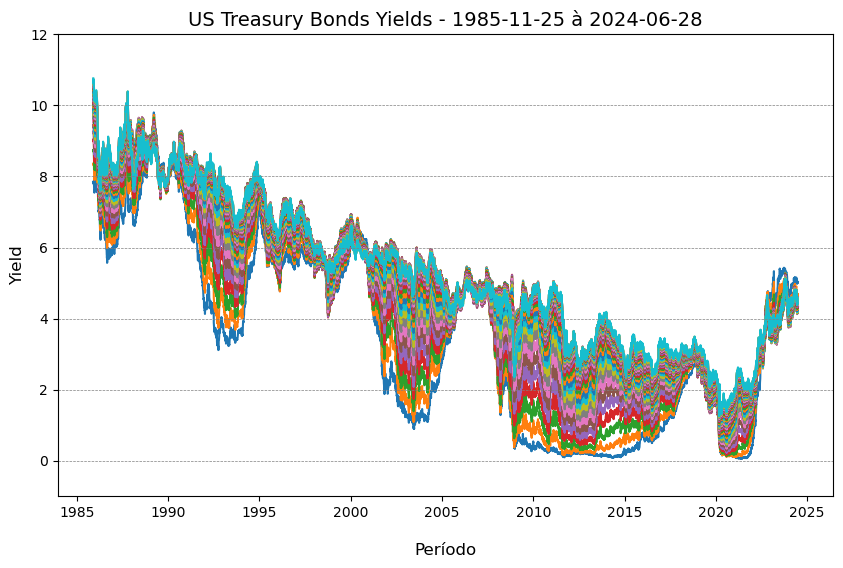

In [6]:
plt.figure(figsize=(10,6))

plt.plot(data)

for y_value in np.arange(0, 13, 2): 
    plt.axhline(y=y_value, color='gray', linestyle='--', linewidth=0.5)

plt.title(f'US Treasury Bonds Yields - {data.index[0].date()} à {data.index[-1].date()}', fontsize = 14)
plt.ylabel('Yield', fontsize = 12)
plt.ylim(bottom=-1, top=12)
plt.xlabel('\nPeríodo', fontsize = 12)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(5)) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.show()

No gráfico abaixo plotamos a curva de juros de de junho de 2023 até junho de 2024 (252 dias úteis) e podemos observar um aumento dos juros em praticamente todos os vencimentos, isso indica que houve um aumento do nível de juros. 

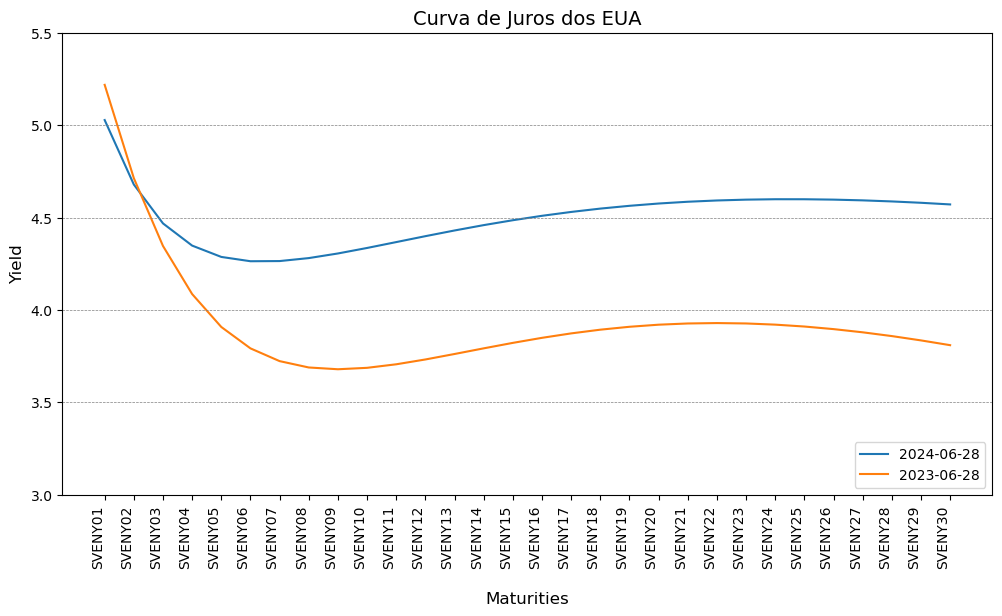

In [7]:
plt.figure(figsize=(12,6))

plt.plot(data.iloc[-1], label = data.index[-1].date())
plt.plot(data.iloc[-252], label = data.index[-252].date())

plt.title(f'Curva de Juros dos EUA', fontsize = 14)

for y_value in np.arange(0, 6, 0.5): 
    plt.axhline(y=y_value, color='gray', linestyle='--', linewidth=0.5)
plt.ylabel('Yield', fontsize = 12)
plt.ylim(bottom=3, top=5.5)

plt.xlabel('\nMaturities', fontsize = 12)
plt.xticks(rotation=90, ha="right");

plt.legend(loc='lower right')

É importante dizer que além do nível de juros, quando comparamos diferentes janelas também podemos observar mudanças na inclinação e na curvatura da curva como a observada no gráfico abaixo.

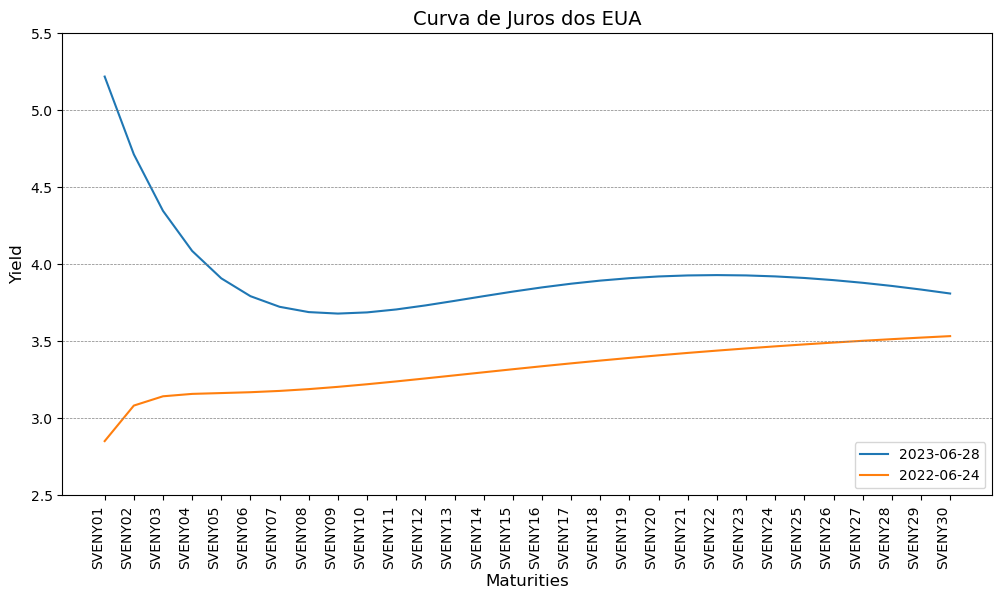

In [8]:
plt.figure(figsize=(12,6))

plt.plot(data.iloc[-252*1], label = data.index[-252*1].date())
plt.plot(data.iloc[-252*2], label = data.index[-252*2].date())

plt.title(f'Curva de Juros dos EUA', fontsize = 14)

for y_value in np.arange(0, 5.5, 0.5): 
    plt.axhline(y=y_value, color='gray', linestyle='--', linewidth=0.5)
plt.ylabel('Yield', fontsize = 12)
plt.ylim(bottom=2.5, top=5.5)

plt.xlabel('Maturities', fontsize = 12)
plt.xticks(rotation=90, ha="right");

plt.legend(loc='lower right')

### Correlação entre as variáveis

O primeiro passo para fazer a análise de fatores (PCA) é gerar a matriz de correlação que expressa a relação linear das variáveis entre si e apresenta um valor entre +1 e -1, correlações próximas de zero nos leva a supor que não há relação linear entre as variáveis. Neste estudo podemos visualizar que todos os títulos apresentam elevada correlação entre sí (<80), entretanto com títulos apresentam correlação mais elevada ou baixa dependendo do vencimento.

In [9]:
pg.rcorr(data, method = 'pearson', upper = 'pval', 
         decimals = 4, 
         pval_stars = {0.01: '***', 0.05: '**', 0.10: '*'}) #Serve para medir o nível de significância

,SVENY01,SVENY02,SVENY03,SVENY04,SVENY05,SVENY06,SVENY07,SVENY08,SVENY09,SVENY10,...,SVENY21,SVENY22,SVENY23,SVENY24,SVENY25,SVENY26,SVENY27,SVENY28,SVENY29,SVENY30
SVENY01,-,***,***,***,***,***,***,***,***,***,...,***,***,***,***,***,***,***,***,***,***
SVENY02,0.9944,-,***,***,***,***,***,***,***,***,...,***,***,***,***,***,***,***,***,***,***
SVENY03,0.9829,0.9967,-,***,***,***,***,***,***,***,...,***,***,***,***,***,***,***,***,***,***
SVENY04,0.9691,0.9889,0.9977,-,***,***,***,***,***,***,...,***,***,***,***,***,***,***,***,***,***
SVENY05,0.9543,0.9788,0.992,0.9983,-,***,***,***,***,***,...,***,***,***,***,***,***,***,***,***,***
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SVENY26,0.8285,0.872,0.9044,0.9289,0.9473,0.9609,0.9709,0.9781,0.9833,0.9869,...,0.9987,0.9991,0.9995,0.9998,0.9999,-,***,***,***,***
SVENY27,0.8273,0.871,0.9036,0.9281,0.9465,0.9602,0.9701,0.9773,0.9824,0.986,...,0.998,0.9986,0.999,0.9994,0.9997,0.9999,-,***,***,***
SVENY28,0.8262,0.87,0.9027,0.9273,0.9457,0.9593,0.9692,0.9763,0.9814,0.9849,...,0.9972,0.9979,0.9984,0.999,0.9994,0.9997,0.9999,-,***,***
SVENY29,0.8249,0.8689,0.9017,0.9264,0.9448,0.9584,0.9683,0.9753,0.9803,0.9838,...,0.9963,0.997,0.9977,0.9983,0.9989,0.9994,0.9997,0.9999,-,***


O gráfico abaixo é chamado de heatmap e foi gerado pelo plotly. 

In [10]:
corr = data.corr()

fig = go.Figure()

fig.add_trace(
    go.Heatmap(
        x = corr.columns,
        y = corr.index,
        z = np.array(corr),
        text=corr.values,
        texttemplate='%{text:.4f}',
        colorscale='viridis'))

fig.update_layout(
    height = 1000,
    width = 1000,
    yaxis=dict(autorange="reversed"))

fig.show()

### Teste de Barlett (Adequação Global)

A primeira coisa que devemos fazer é verificar se a nossa matriz de correlação é estatisticamente diferente de zero pois não faria sentido tentar extrair fatores que agregam informação das variáveis originais se elas não possuíssem nenhuma relação entre si. Para fazer este teste usamos o teste de esfericidade de Barlett, abaixo vemos que o nosso p-valor foi abaixo de 0.05 e então podemos rejeitar a hipótese nula (H0) de que nossa matriz é estatisticamente igual a 0.

In [11]:
bartlett, p_value = calculate_bartlett_sphericity(data)

print(f'Qui² Bartlett: {round(bartlett, 2)}')
print(f'p-valor: {round(p_value, 4)}')

Qui² Bartlett: 5133406.44
p-valor: 0.0


## Análise de Fatores

A análise de fatores ou de componentes principais (PCA) tem como objetivo reduzir a dimensionalidade de uma base de dados composta normalmente de muitas variáveis, o resultado é a obtenção de um número reduzido de fatores que carreguem informação relevante dos dados originais. Na nossa base de dados originais temos mais de 30 variáveis que são nossos títulos que possuem vencimentos que vão de 1 à 30 anos, buscaremos reduzir a dimensionalidade do nosso conjunto de variáveis de 30 para 3 fatores que são os nossos componentes principais (fatores): nível, inclinação e curvatura.

A biblioteca utilizada foi a biblioteca factor-analyzer que foi apresentada no meu MBA da USP/Esalq, entretanto há outras bibliotecas como a scikit-learn e pode até ser calculada manualmente com a biblioteca numpy pois PCA na prática é álgebra linear. 

Biblioteca: https://factor-analyzer.readthedocs.io/en/latest/factor_analyzer.html

In [12]:
fa = FactorAnalyzer(n_factors=30, method='principal', rotation=None).fit(data)
fa

FactorAnalyzer(method='principal', n_factors=30, rotation=None,
               rotation_kwargs={})

## Autovalores e Autovetores 

A partir da nossa base de dados original que transformamos em uma matriz de correlação (𝜌), podemos transforma-la novamente em uma matriz de autovetores (𝑣) associadas a um escala que é chamado de autovalores (𝜆), na prática daremos maior atenção aos autovalores de maior magnitude visto que capturariam a maior parte da variabilidade da minha base original de dados, com este autovalor e sua respectiva matriz de autovetores conseguiremos calcular os fatores onde cada um deles poderia ser utilizado para explicar um dos componentes da nossa curva de juros (nível, inclinação e curvatura).

A fórmula para encontrar os autovalores e autovetores está representado abaixo: 

$
A \cdot \mathbf{v} = \lambda \cdot \mathbf{v} \newline
$
Onde A é a minha matriz original, no caso do PCA a nossa matriz original é a matriz de correlação $\rho$. Podemos reorganizar como: 

$
\rho \cdot \mathbf{v} - \lambda \cdot \mathbf{v} = 0 \newline
$
$
(\rho - \lambda \cdot \mathbf{I}) \cdot \mathbf{v} = 0
$

Encontramos os autovalores resolvendo o determinante abaixo: 

$
\det(\rho - \lambda \cdot \mathbf{I}) = 0
$

É importante notar que o número de autovalores é igual ao ordem da nossa matriz quadrática ou podemos pensar mais intuitivamente ao número ($n$) de variáveis da minha matriz original ($A = \rho$). Após encontrar os autovalores, substituímos na matriz inicial ($\rho - \lambda \cdot \mathbf{I}$) e resolvemos $(\rho - \lambda \cdot \mathbf{I}) \cdot \mathbf{v} = 0$, como cada autovalor ($\lambda$) assume um valor diferente teremos n matrizes de autovetores associada a cada um dos autovalores. Outro detalhe importante é que os meus autovalores representam as variâncias da minha base de dados associadas as novas coordenadas formadas a partir desta transformação linear que fazemos. 

### Links Úteis

- Principal Component Analysis (PCA): https://www.youtube.com/watch?v=g-Hb26agBFg&t=1156s
- Eigenvectors and Eigenvalues Explained Visually: https://setosa.io/ev/eigenvectors-and-eigenvalues/
- Online Eigenvalue Calculator: https://www.wolframalpha.com/input?i2d=true&i=%7B%7B1%2C3%7D%2C%7B2%2C2%7D%7D

### Extração autovalores com a biblioteca factor_analyser

Abaixo extraímos os autovalores ($\lambda$) onde podemos verificar que o primeiro autovalor captura quase toda a variância, enquanto os autovalores seguintes vão diminuindo até se tornarem tão pequenos que se tornam irrelevantes. 

In [13]:
autovalores = fa.get_eigenvalues()[0]

print('Autovalores:\n\n', list(np.round(autovalores, 4)))

print('\nNúmero de Autovalores:', int(autovalores.sum()))

Autovalores:

 [29.1442, 0.7843, 0.0471, 0.0211, 0.0029, 0.0003, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Número de Autovalores: 30


### Extração com a biblioteca SymPy

Para trabalhar com matrizes em Python podemos utilizar também o SymPy.

Biblioteca: https://docs.sympy.org/latest/tutorials/intro-tutorial/matrices.html

In [14]:
sy.init_printing(scale=10)

matriz = sy.Matrix(corr)
matriz.applyfunc(lambda x: x.round(3)) #Apenas para melhor vizualização

⎡ 1.0   0.994  0.983  0.969  0.954  0.939  0.925  0.912  0.899  0.888  0.879  
⎢                                                                             
⎢0.994   1.0   0.997  0.989  0.979  0.968  0.956  0.945  0.935  0.925  0.917  
⎢                                                                             
⎢0.983  0.997   1.0   0.998  0.992  0.984  0.976  0.967  0.958  0.95   0.943  
⎢                                                                             
⎢0.969  0.989  0.998   1.0   0.998  0.994  0.988  0.982  0.975  0.969  0.963  
⎢                                                                             
⎢0.954  0.979  0.992  0.998   1.0   0.999  0.995  0.991  0.986  0.981  0.976  
⎢                                                                             
⎢0.939  0.968  0.984  0.994  0.999   1.0   0.999  0.997  0.993  0.99   0.986  
⎢                                                                             
⎢0.925  0.956  0.976  0.988  0.995  0.999   1.0   0.

Extraímos os autovalores com o eigenvals():

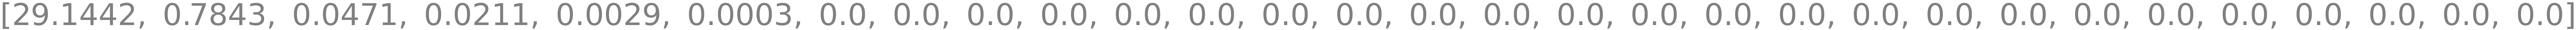

In [15]:
sorted([round(i, 4) for i in matriz.eigenvals().keys()], reverse=True) #Apenas para melhor vizualização

Extraímos os autovatores com o eigenvectors(), separei apenas os dois primeiros que estão associados aos dois primeiros autovalores a pretexto de ilustração:

In [16]:
matriz.eigenvects()[:2]

⎡⎛                     ⎡⎡0.164435397513941⎤⎤⎞  ⎛                      ⎡⎡-0.507
⎢⎜                     ⎢⎢                 ⎥⎥⎟  ⎜                      ⎢⎢      
⎢⎜                     ⎢⎢0.171128130846508⎥⎥⎟  ⎜                      ⎢⎢-0.429
⎢⎜                     ⎢⎢                 ⎥⎥⎟  ⎜                      ⎢⎢      
⎢⎜                     ⎢⎢0.175797561790886⎥⎥⎟  ⎜                      ⎢⎢-0.354
⎢⎜                     ⎢⎢                 ⎥⎥⎟  ⎜                      ⎢⎢      
⎢⎜                     ⎢⎢0.179101561739549⎥⎥⎟  ⎜                      ⎢⎢-0.285
⎢⎜                     ⎢⎢                 ⎥⎥⎟  ⎜                      ⎢⎢      
⎢⎜                     ⎢⎢0.181409233920918⎥⎥⎟  ⎜                      ⎢⎢-0.223
⎢⎜                     ⎢⎢                 ⎥⎥⎟  ⎜                      ⎢⎢      
⎢⎜                     ⎢⎢0.182967128270698⎥⎥⎟  ⎜                      ⎢⎢-0.168
⎢⎜                     ⎢⎢                 ⎥⎥⎟  ⎜                      ⎢⎢      
⎢⎜                     ⎢⎢0.183966198912154⎥⎥⎟  ⎜    

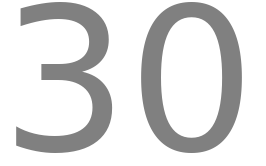

In [17]:
len(matriz.eigenvects()) # Número de matrizes de autovetores

Abaixo obtemos o polinômio característico dos autovalores, lembrando que ele é fruto da fórmula apresentada anteriormente sobre autovalores e autovatores.

In [18]:
lamda = sy.symbols('lambda')
polinomio = matriz.charpoly(lamda)
polinomio

PurePoly(1.0*lambda**30 - 30.0*lambda**29 + 24.9981339063666*lambda**28 - 1.66
941500893621*lambda**27 + 0.0278579271088951*lambda**26 - 7.45472234855641e-5*
lambda**25 + 1.5106553420597e-8*lambda**24 - 1.02133362898245e-7*lambda**23 - 
1.94137674107964e-6*lambda**22 - 2.3027474790132e-5*lambda**21 + 0.00026131641
7239061*lambda**20 + 0.140535363105265*lambda**19 - 3.46627886104606*lambda**1
8 - 15.1302048954214*lambda**17 + 1531.07730633786*lambda**16 + 3383.375559559
37*lambda**15 - 441180.116371133*lambda**14 - 24251583.415872*lambda**13 - 318
040725.155289*lambda**12 + 28317466859.5131*lambda**11 - 37594142288.0437*lamb
da**10 + 36857023814411.7*lambda**9 - 671016011940077.0*lambda**8 + 2.27710543
379612e+16*lambda**7 + 7.10403453519466e+16*lambda**6 - 4.07214025872784e+19*l
ambda**5 + 1.09445900365942e+21*lambda**4 - 1.29424904615679e+22*lambda**3 - 2
.99714906460919e+23*lambda**2 + 2.72882807888472e+24*lambda + 2.44339040788864
e+26, lambda, domain='RR')

### Extração com SciPy

Podemos também obter por meio da biblioteca Scipy.

Biblioteca: https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.eigh.html

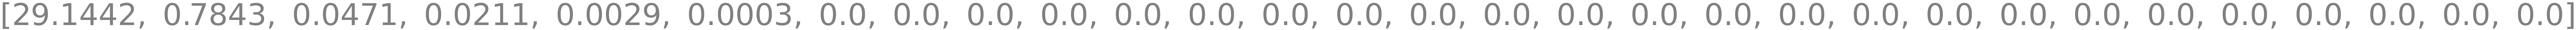

In [19]:
autovalores, autovetores = sp.linalg.eigh(corr)

list([round(i, 4) for i in autovalores[::-1]])

## Tabela de Variância Compartilhada

A tabela abaixo mostra a variância compartilhada dos autovalores (𝜆) para a formação de cada fator, o primeiro fator sempre terá a maior variância compartilhada enquanto os demais terão variâncias sequencialmente menores.

In [20]:
autovalores_fatores = fa.get_factor_variance()
tabela_eigen = pd.DataFrame(autovalores_fatores)

# Loop para nomear cada coluna no seu respectivo fator
fator_coluna = []
for i in tabela_eigen:
    fator_coluna.append(f"Fator {i+1}")
    
tabela_eigen.columns = fator_coluna
tabela_eigen.index = ['Autovalor','Variância', 'Variância Acumulada']
tabela_eigen = tabela_eigen.T
round(tabela_eigen,4)

,Autovalor,Variância,Variância Acumulada
Fator 1,29.1442,0.9715,0.9715
Fator 2,0.7843,0.0261,0.9976
Fator 3,0.0471,0.0016,0.9992
Fator 4,0.0211,0.0007,0.9999
Fator 5,0.0029,0.0001,1.0000
...,...,...,...
Fator 26,0.0000,0.0000,1.0000
Fator 27,0.0000,0.0000,1.0000
Fator 28,0.0000,0.0000,1.0000
Fator 29,0.0000,0.0000,1.0000


Podemos representar a tabela acima em um gráfico de barras e verificar como os fatores 1, 2 e 3 explicam praticamente 99,9% da variância total. 

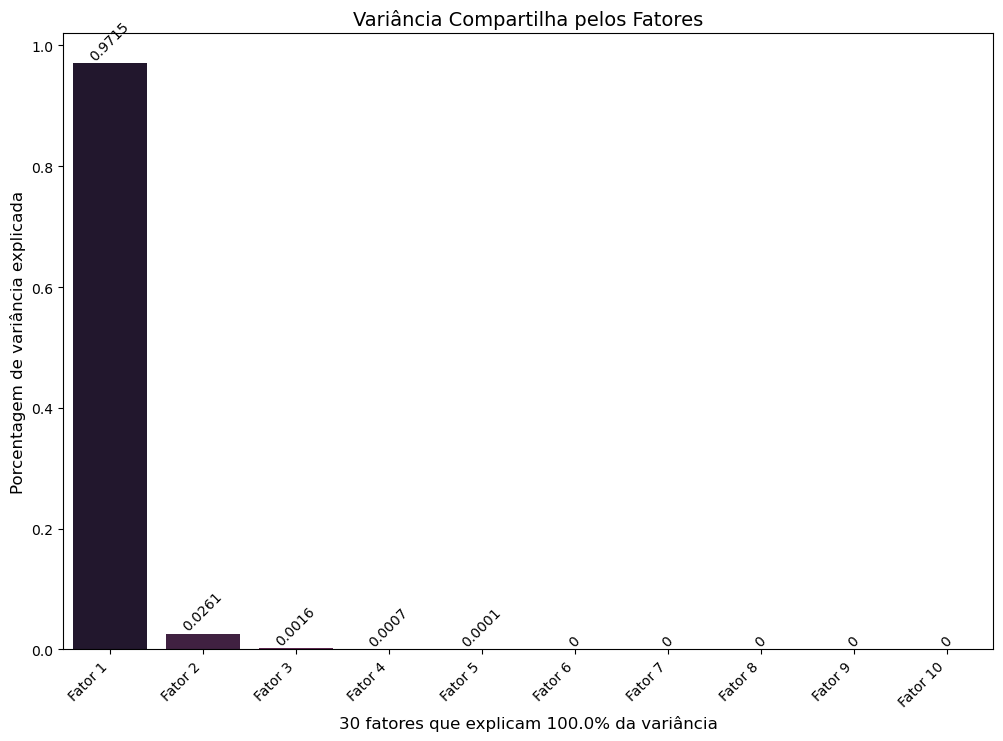

In [21]:
plt.figure(figsize=(12,8))
ax = sns.barplot(x=tabela_eigen.index[0:10], y=round(tabela_eigen['Variância'][0:10],4), data=tabela_eigen, palette='rocket')
plt.bar_label(ax.containers[0], rotation=45)
plt.title("Variância Compartilha pelos Fatores", fontsize=14)
plt.xlabel(f"{tabela_eigen.shape[0]} fatores que explicam {round(tabela_eigen['Variância'].sum()*100,2)}% da variância", fontsize=12)
plt.ylabel("Porcentagem de variância explicada", fontsize=12)
plt.xticks(rotation=45, ha="right");

### Comunalidades

Como a maioria dos fatores explicam pouco do comportamento das minhas variáveis (baixa variância compartilhada) podemos remove-los e manter apenas os três primeiros fatores. Para mensurar a "perda de informação" com a remoção de fatores fazemos o que é chamado de análise de comunalidade, ao usar todos os fatores a comunalidade é sempre igual a 1, ao remover podemos ver que o impacto por ínfimo. Isso nos dá a segurança que a escolha de três fatores não prejudicou a "explicabilidade" de nenhuma das variáveis.  

In [22]:
fa_reduced = FactorAnalyzer(n_factors=3, method='principal', rotation=None).fit(data)
comunalidades = fa_reduced.get_communalities()

tabela_comunalidades = pd.DataFrame(comunalidades)
tabela_comunalidades.columns = ['Comunalidades']
tabela_comunalidades.index = data.columns

tabela_comunalidades

,Comunalidades
SVENY01,0.992972
SVENY02,0.999359
SVENY03,0.999430
SVENY04,0.998670
SVENY05,0.998237
...,...
SVENY26,0.999984
SVENY27,0.999896
SVENY28,0.999675
SVENY29,0.999294


## Fatores

Obtemos os nossos fatores por meio da função .transform() da biblioteca factor_analyzer:

In [23]:
fatores = pd.DataFrame(fa.transform(data))
fatores.columns = fator_coluna
fatores.index = data.index
fatores.iloc[:,0:3]

,Fator 1,Fator 2,Fator 3
Date,,,
1985-11-25,2.317876,-0.987101,2.324974
1985-11-26,2.307995,-0.946096,2.085929
1985-11-27,2.293369,-0.928757,2.225968
1985-11-29,2.274521,-0.932945,2.316055
1985-12-02,2.314500,-1.000002,2.243183
...,...,...,...
2024-06-24,-0.251757,1.519291,0.600898
2024-06-25,-0.258082,1.526854,0.615549
2024-06-26,-0.220231,1.498200,0.543592


Uma propriedade importante dos fatores obtidos é que possuem correlação nula, isso é uma propriedade interessante visto que um problema comum em análise de regressão é a multicolinearidade que é a presença de relação linear entre as variáveis explicativas. O ideal é ter variáveis que sejam independentes e que contribuam com informação, ou seja, que não sejam "redundantes". 

In [24]:
pg.rcorr(fatores.iloc[:,0:3], method = 'pearson', upper = 'pval', 
         decimals = 4, 
         pval_stars = {0.01: '***', 0.05: '**', 0.10: '*'})

,Fator 1,Fator 2,Fator 3
Fator 1,-,,
Fator 2,-0.0,-,
Fator 3,-0.0,-0.0,-


### Cargas Fatoriais

As cargas fatoriais nada mais são do que a correlação linear de Pearson entre os fatores extraídos e as variáveis originais, essa informação é importante pois indica como as variáveis se comportam em cada um dos fatores.

In [25]:
cargas_fatoriais = fa.loadings_

tabela_cargas = pd.DataFrame(cargas_fatoriais)
tabela_cargas.columns = fator_coluna # que geramos anteriormente
tabela_cargas.index = data.columns

tabela_cargas.iloc[:,0:3]

,Fator 1,Fator 2,Fator 3
SVENY01,0.887711,0.449529,0.053525
SVENY02,0.923842,0.380418,0.034028
SVENY03,0.949050,0.313677,0.018472
SVENY04,0.966887,0.252547,0.004473
SVENY05,0.979345,0.197609,-0.008416
...,...,...,...
SVENY26,0.991704,-0.120139,0.045531
SVENY27,0.991055,-0.121452,0.054352
SVENY28,0.990285,-0.122568,0.063143
SVENY29,0.989378,-0.123524,0.071876


Abaixo calculamos manualmente a carga fatorial e vemos que ela é de fato igual a correlação do fator gerado com as variáveis originais. 

In [26]:
(pd.concat([fatores['Fator 1'], data], axis = 1).corr()).iloc[0,1:].T

SVENY01    0.887711
SVENY02    0.923842
SVENY03    0.949050
SVENY04    0.966887
SVENY05    0.979345
             ...   
SVENY26    0.991704
SVENY27    0.991055
SVENY28    0.990285
SVENY29    0.989378
SVENY30    0.988319
Name: Fator 1, Length: 30, dtype: float64

Abaixo plotamos as cargas fatoriais dos nossos três fatores e podemos levantar as seguintes hipóteses:

- Fator 1: Indica que os títulos sob um certo aspecto tem um comportamento muito semelhante. 

- Fator 2: Indica que sob um outro aspecto os títulos de vencimentos mais curtos comportam-se diferente na medida que caminhamos para vencimentos mais longos.

- Fator 3: Indica que os vencimentos curtos e longos apresentam sob um outro aspecto um comportamento diferente em relação aos vencimentos intermediários. 

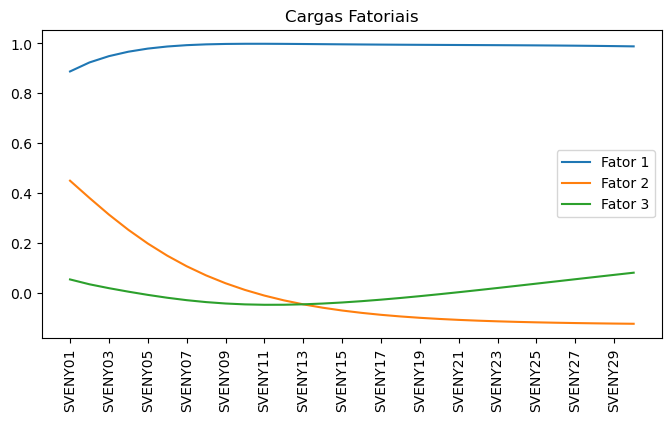

In [27]:
plt.figure(figsize=(8,4))

plt.title('Cargas Fatoriais')
plt.plot(tabela_cargas.iloc[:,0:3])
plt.xticks(tabela_cargas.index[::2], rotation=90)
plt.legend(tabela_cargas.columns)

plt.show()

### Fatores e Variáveis Originais

Abaixo podemos visualizar a relação dos fatores e das variáveis originais e verificar se os fatores extraídos representam realmente os componentes esperados da curva de juros (nível, inclinação e curvatura): 

- Fator 1 (Nível) : Podemos verificar que o Fator 1 se alinha muito bem ao resultado obtido da média dos diferentes yields, isso demonstra que os yields de títulos mesmo de diferentes vencimentos seguem um tendência. 

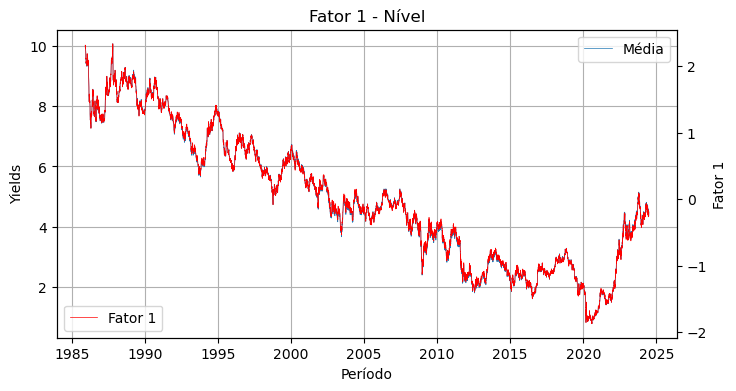

In [28]:
fig, ax1 = plt.subplots(figsize=(8,4))

plt.title('Fator 1 - Nível')

ax1.plot(data.mean(axis=1), label = 'Média', linewidth=0.5)
ax1.set_ylabel('Yields')
ax1.set_xlabel('Período')
ax1.legend()
plt.grid()

ax2 = ax1.twinx()

ax2.plot(fatores.iloc[:,0], label = 'Fator 1', color = 'red', linewidth=0.5)
ax2.set_ylabel('Fator 1')
ax2.legend(loc='lower left')

- Fator 2 (Inclinação) : Vemos que o fator extraído se alinha bem a diferença dos yields de curto prazo (1Y) com os de longo prazo (30Y), isso é um proxy da inclinação da curva de juros e o fator conseguiu capturar relativamente bem esta relação. 

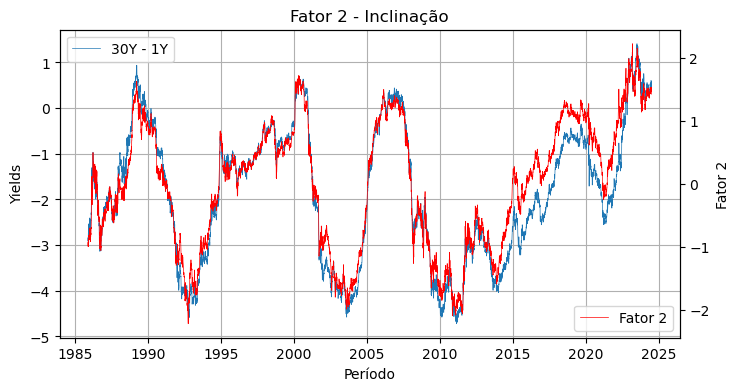

In [29]:
fig, ax1 = plt.subplots(figsize=(8,4))

plt.title('Fator 2 - Inclinação')
ax1.plot(data['SVENY01']-data['SVENY30'], label = '30Y - 1Y', linewidth=0.5)
ax1.set_ylabel('Yields')
ax1.set_xlabel('Período')
ax1.legend()
plt.grid()

ax2 = ax1.twinx()

ax2.plot(fatores.iloc[:,1], label = 'Fator 2', color = 'red', linewidth=0.5)
ax2.set_ylabel('Fator 2')
ax2.legend(loc='lower right')

- Fator 3 (Curvatura) : A curvatura depende dos yields de curto, médio e longo prazo, podemos pensar na diferença dos yields de curto prazo (1Y) com os de médio prazo (10Y) e os de longo prazo (30Y) com os de médio prazo (10Y), calcumos uma aproximação da curvatura como sendo igual a (0Y + 30Y - 2 * 10Y) e o resultado alinhou-se razoavelmente bem ao fator extraído. 

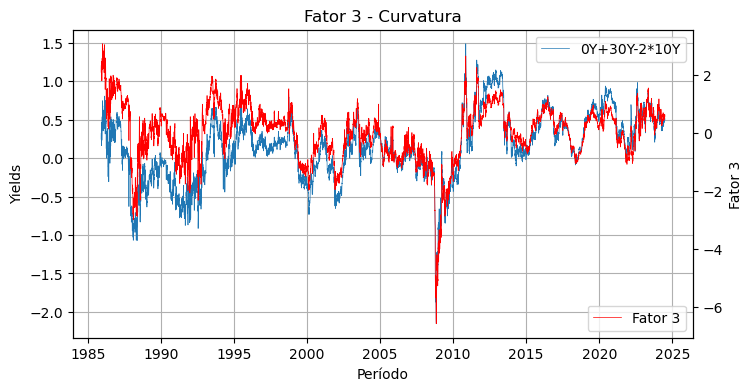

In [30]:
fig, ax1 = plt.subplots(figsize=(8,4))

plt.title('Fator 3 - Curvatura')
ax1.plot(data['SVENY03']+data['SVENY30']-2*data['SVENY07'], label = '0Y+30Y-2*10Y', linewidth=0.5)
ax1.set_ylabel('Yields')
ax1.set_xlabel('Período')
ax1.legend()
plt.grid()

ax2 = ax1.twinx()

ax2.plot(fatores.iloc[:,2], label = 'Fator 3', color = 'red', linewidth=0.5)
ax2.set_ylabel('Fator 3')
ax2.legend(loc='lower right')